In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

### Знакомство с данными, обработка пропусков и выбросов

#### Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

#### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

#### Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

#### Целевая переменная.
* deposit - определяет, согласится ли клиент открыть депозит в банке.

In [2]:
df = pd.read_csv('bank_fin.zip', sep = ';')

In [3]:
#Проверка на пропуски
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

В признаке 'balance' 25 пропусков.

In [4]:
#Проверка признака 'job' на неявные пропуски.
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

В признаке неявные пропуски закодированы словом "unknown" в кол-ве 70.

In [5]:
#проверка на неявные пропуски в признаке 'education'
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

В признаке неявные пропуски закодированы словом "unknown" в кол-ве 497.

In [6]:
#корректировка признака 'balance'
df['balance'] = df['balance'].apply(lambda x: str(x).replace('$', '').replace("'", "").replace(',','.').replace(' ', ''))
df['balance'] = df['balance'].astype(float)

In [7]:
#среднее значение до заполнения нулей
df['balance'].mean().round(3)

1529.129

In [8]:
#замена пропусков медианным значением в признаке 'balance'

df['balance'] = df['balance'].fillna(df['balance'].median())

In [9]:
balance_mean = df['balance'].mean().round(3)
print(f"Среднее значение в признаке 'balace' = {balance_mean}")

Среднее значение в признаке 'balace' = 1526.936


In [10]:
#замена пропусков в признаке 'job' и 'education'
df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['job'].value_counts()

job
management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: count, dtype: int64

In [11]:
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])
df['education'].value_counts()

education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64

In [12]:
#средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования

df_top_balance =  df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]
top_mean_balance = df_top_balance['balance'].mean().round(3)
print(f'Срдений баланс = {top_mean_balance}')


Срдений баланс = 1598.883


In [13]:
#поиск выбросов с помощью метода Тьюки в признаке 'balance'

q1 = df['balance'].quantile(0.25)
q3 = df['balance'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f'Нижняя граница равна: {lower_bound}')
print(f'Верхняя граница равна: {upper_bound}')

# Фильтруем данные, удаляя выбросы
f_df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

print(f'Кол-во строк в датафрейме: {f_df.shape[0]}')


Нижняя граница равна: -2241.0
Верхняя граница равна: 4063.0
Кол-во строк в датафрейме: 10105


### Разведовательный анализ данных.

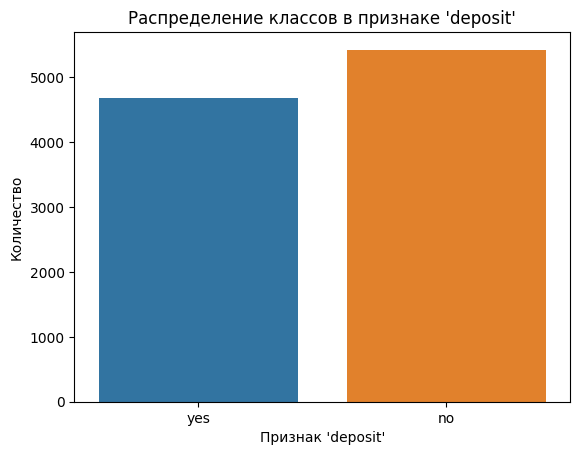

Клиентов открывших депозит: 4681


In [14]:
#проверка целевого признака на сбалансированность

sns.countplot(data = f_df, x = 'deposit')
plt.title("Распределение классов в признаке 'deposit'")
plt.xlabel("Признак 'deposit'")
plt.ylabel('Количество')

plt.show()
count_dep = f_df['deposit'].value_counts()
print(f'Клиентов открывших депозит: { count_dep[1]}')


---------------
* Из графика следует вывод, что данные несбалансированны.
------------------

In [15]:
#описательная статистика для числовых признаков
f_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


---------------
### Выводы по описательной статистике для числовых признаков:
* В признаке 'age' стоит обратить внимание на максимальный возраст в 95 лет. 75% значений находятся в интервале от 18 до 48 лет.
* В признаке 'balance' всё выглядит приемлемо, т.к. от выбросы были удалены ранее.
* В признаке 'duration' стоит обратить внимание на максимальнок значение в 3881 секунду, т.к. исходя из этого кол-ва секунд, продолжительность общения составила более часа. Так же 75% значений находятся в интервале от 2 до 490 секунд. Стоит так же обратить внимание на минимальный показатель в две секунды и на мелкие значения.
* В признаке 'pdays' также стоит обратить внимание на максимальные значения, т.к. судя по статистике большая часть данных варьируется в пределах -1 - 2.
* В признаке 'previous' тоже стоит обратить внимание на максимальное значение, т.к. большая часть данных находится в интервале от 0 -1.
--------------

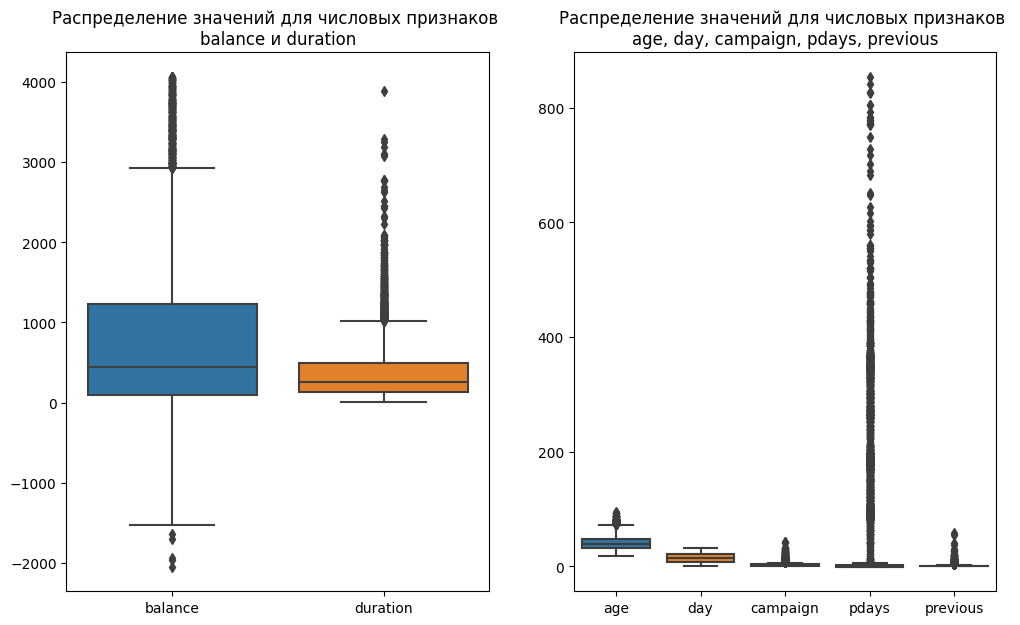

In [16]:
# Создаем фигуру для графика
fig, axes = plt.subplots(1, 2,figsize=(12, 7))

# Перебираем каждый столбец данных и строим boxplot на соответствующих осях
df_boxplot = f_df.select_dtypes(include=np.number)
axes[0] = sns.boxplot(data = df_boxplot[['balance', 'duration']], ax = axes[0])


axes[1] = sns.boxplot(data = df_boxplot[['age', 'day', 'campaign', 'pdays', 'previous']], ax = axes[1])
 
axes[0].set_title('Распределение значений для числовых признаков \nbalance и duration')
axes[1].set_title('Распределение значений для числовых признаков \nage, day, campaign, pdays, previous')
plt.show()

---------------------
### Выводы по графику:
* Большое кол-во выбросов наблюдается в признаках 'duration', 'pdays' и 'balance'.
* Малое кол-во выбросов в признаках 'age', 'campaign', 'previous'.
* В признаке 'day' выбросов нет.
* Возможно выбросы в некоторых признаках являются естесвенными аномалиями.
---------------------

In [17]:
#описательная статистика для категориальных переменных
f_df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


---------------
### Выводы по описательной статистике для категориальных переменных:
* Самая популярная сфера занятости среди клиентов - 'managment'.
* Чаще всего клиенты женаты.
* Образование чаще всего - среднее.
* Просроченных кредитов, чаще всего нет.
* Кредитов на дом, чаще всего нет.
* Кредиты на личные нужды, чаще всего отсутствуют.
* Самый популярный тип контакта с клиентом - с помощью сотового телефона.
* Месяц, в котором было наибольшее кол-во последних контактво с клиентами  - май.
* Чаще всего неизвестно результат прошлой маркетинговой компанни неизвестен.
* Клиентов у которых депозита нет, больше, чем тех, у кого он есть.
* Так же можно отметить, что помимо целевой переменной 'deposit', признаки: 'default', 'housing', 'loan' - имеют бинарный характер.
-----------------

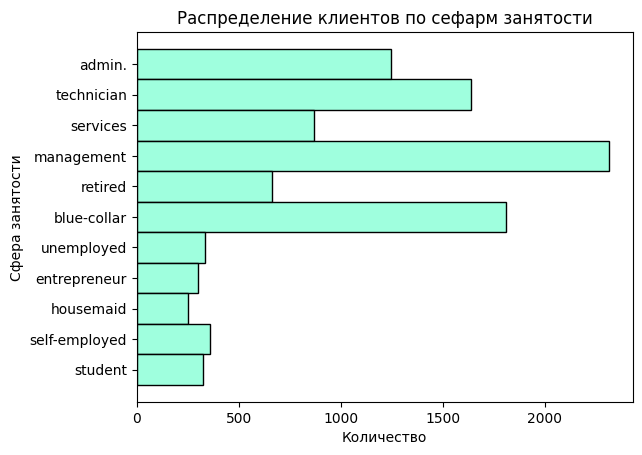

In [18]:
#график распределения признака 'job'
sns.histplot(data = f_df, y =f_df['job'], color = '#7FFFD4')
plt.title('Распределение клиентов по сефарм занятости')
plt.ylabel('Сфера занятости')
plt.xlabel('Количество')

plt.show()

In [19]:
#Среднее значение баланса у клиентом со статусом - предпрениматель(enterpreneur)
mean_enter = f_df[f_df['job'] == 'entrepreneur']['balance'].mean().round(2)
print(f'Среднее значение баланса у клиентом со статусом - предпрениматель {mean_enter}')

Среднее значение баланса у клиентом со статусом - предпрениматель 758.05


-----------
### Выводы по графику:
* Больше всего клиентов работают менеджерами.
* Следом идут голубые воротнички (рабочие среднего класса), техники и администраторы.
* В целом можно сказать, что банком в оснвоном пользуются люди среднего достатка и мелких предпринимателей.
-----------

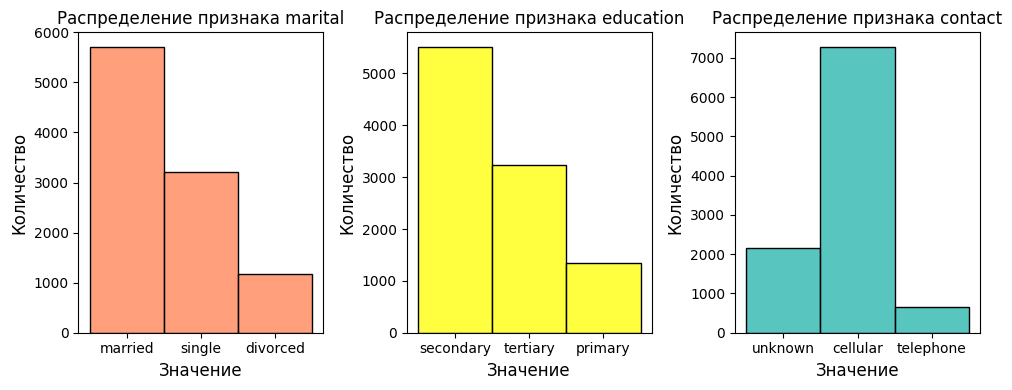

In [20]:
#график распределения признаков 'marital', 'education', 'contact'
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
df_1_3 = f_df[['marital','education','contact']]
color_3 = ['#FF7F50', '#FFFF00', '#20B2AA']
#перебор признаков с построением графика для каждого
for i, col in enumerate(df_1_3.keys()):
    
    ax = sns.histplot(data=df_1_3[col], ax=axes[i], color = color_3[i])
    ax.set_title(f'Распределение признака {col}')
    ax.set_xlabel('Значение', fontsize= 12)
    ax.set_ylabel('Количество', fontsize= 12)
plt.tight_layout()
plt.show()

----------
### Выводы по графику:
* Больше всего клиентов семейных ( около 5900), далее идут незамужние - неженатые (около 3300), меньше всего раведённых (около 1200).
* Больше всего клиентов со срденим образованием (около 5500), далее идут клиенты с высшим образованием (около 3200) и меньше всего с начальным образованием (около 1500)ю
* Большая часть клиентов предпочитает связываться по мобильному телефону.
------------

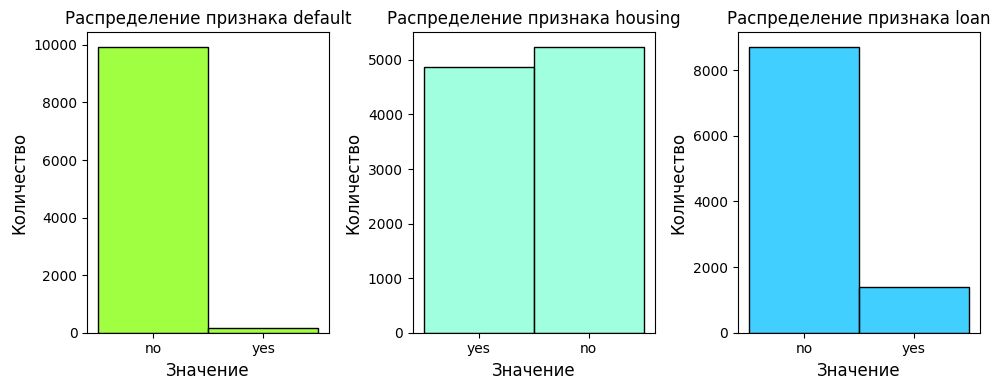

In [21]:
#график распределения признаков  'default','housing', 'loan'.
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
df_4_6 = f_df[['default', 'housing', 'loan']]
color_3 = ['#7FFF00', '#7FFFD4', '#00BFFF']
#перебор признаков с построением графика для каждого
for i, col in enumerate(df_4_6.keys()):
    
    ax = sns.histplot(data=df_4_6[col], ax=axes[i], color = color_3[i])
    ax.set_title(f'Распределение признака {col}')
    ax.set_xlabel('Значение', fontsize= 12)
    ax.set_ylabel('Количество', fontsize= 12)
plt.tight_layout()
plt.show()


--------------
### Выводы по графикам:
* Просроченных кредитов практически ни у кого нет.
* Почти половина клиентов имеет кредит на жильё.
* Кредит на личные нужды есть примерно у 1600 клиентов.
------------------


Text(0, 0.5, 'Количество')

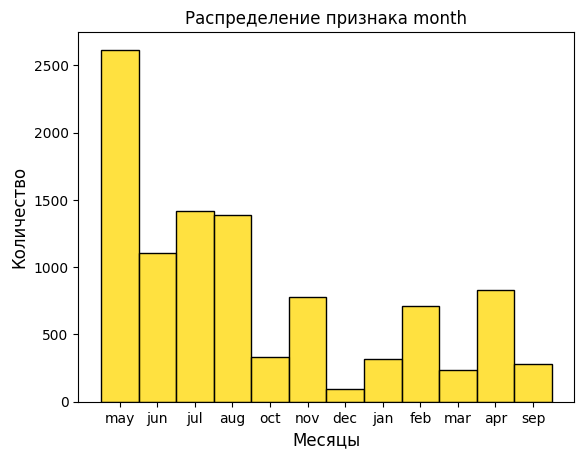

In [22]:
sns.histplot(data = f_df, x = 'month', color='#FFD700')

plt.title('Распределение признака month')
plt.xlabel('Месяцы', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)

In [24]:
# В каком месяце было больше всего отказов на общее кол-во принятых решений

group_fail = f_df.groupby('month')['deposit'].value_counts().reset_index()
grouped_data =  group_fail.groupby(['month', 'deposit'])['count'].sum().unstack()

# Вычисляем отношение запросов к отказам
grouped_data['ratio'] = grouped_data['yes'] / grouped_data['no']

grouped_data.sort_values(by='ratio')

deposit,no,yes,ratio
month,,,
may,1776,841,0.473536
jan,194,125,0.644330
jul,836,582,0.696172
nov,456,324,0.710526
aug,775,610,0.787097
jun,606,498,0.821782
feb,323,386,1.195046
apr,317,513,1.618297
oct,62,273,4.403226


* Больше всего отказов было в мае месяце.

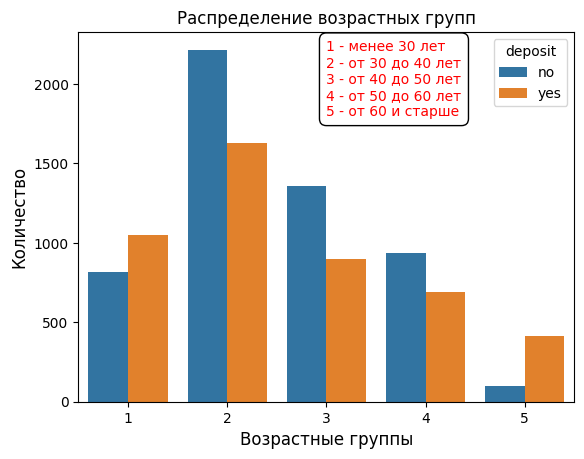

In [25]:
# Создание функции для распределения клиентов по возрастным группам
def sort_age(x):
    if x <= 30:
        return 1
    if x > 30  and x <=40:
        return 2
    if x > 40 and x <=50:
        return 3
    if x > 50 and x <=60:
        return 4
    else: 
        return 5
    
f_df['age_new'] = f_df['age'].apply(sort_age)
# Необходимо определить какие группы чаще соглашаются на депозит, чем отказываются
group_age  = f_df.groupby('age_new')['deposit'].value_counts().reset_index()
#Замена показателей в окошке 'hue' на графике
group_age['deposit'] = pd.Categorical(group_age['deposit'])

sns.barplot(group_age, x="age_new", y="count", hue="deposit")
plt.title('Распределение возрастных групп')
plt.xlabel('Вoзрастные группы', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.text(2, 1800, '1 - менее 30 лет\n2 - от 30 до 40 лет\n3 - от 40 до 50 лет\n4 - от 50 до 60 лет\n5 - от 60 и старше', fontsize=10, color='red',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.show()


----------------
### Выводы по графику:
* Группы 1(до 30 лет) и 5 (старше 60-ти лет), склонны чаще соглашаться на депозит, нежели все остальные группы (от 30 до 60-ти лет).
-----------------

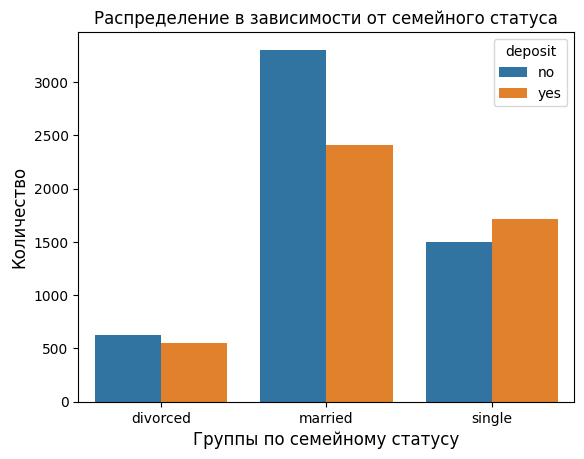

In [26]:
#создание визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
group_marital = f_df.groupby('marital')['deposit'].value_counts().reset_index()

sns.barplot(group_marital, x="marital", y="count", hue="deposit")
plt.title('Распределение в зависимости от семейного статуса')
plt.xlabel('Группы по семейному статусу', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.show()

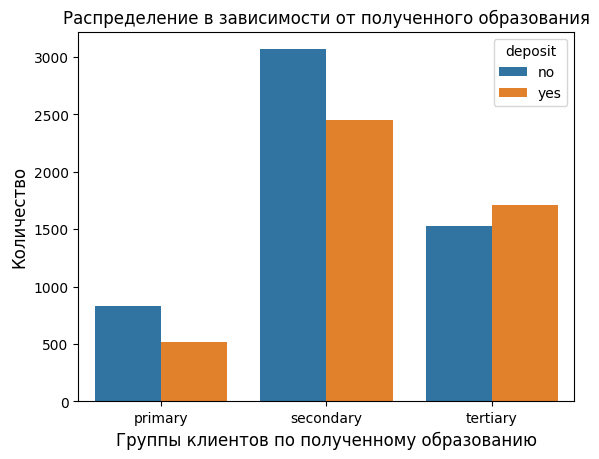

In [27]:
#создание визуализации для открывших и неоткрывших депозит в зависимости от образования
group_edu = f_df.groupby('education')['deposit'].value_counts().reset_index()

sns.barplot(group_edu, x="education", y="count", hue="deposit")
plt.title('Распределение в зависимости от полученного образования')
plt.xlabel('Группы клиентов по полученному образованию', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.show()


--------
### Выводы по графику:
* В группе у клиентов с высшим образованием превалирует группа тех, кто не стал пользоваться депозитом, в сравнении с теми, кто воспользовался услугой.
* В группе клиентов со средним образованием больше всего людей.
* Следом идёт группа с высшим образованием. В ней превалирует группа тех, кто воспользовался депозитом, но разница в сравнении с теми, кто не стал им пользоваться не выскоая.
* Самые низкие показатели в группе клиентов, у которых начальное образование. Тех, кто воспользовался депозитом, больше, чем тех, кто этого делать не стал.
-----------

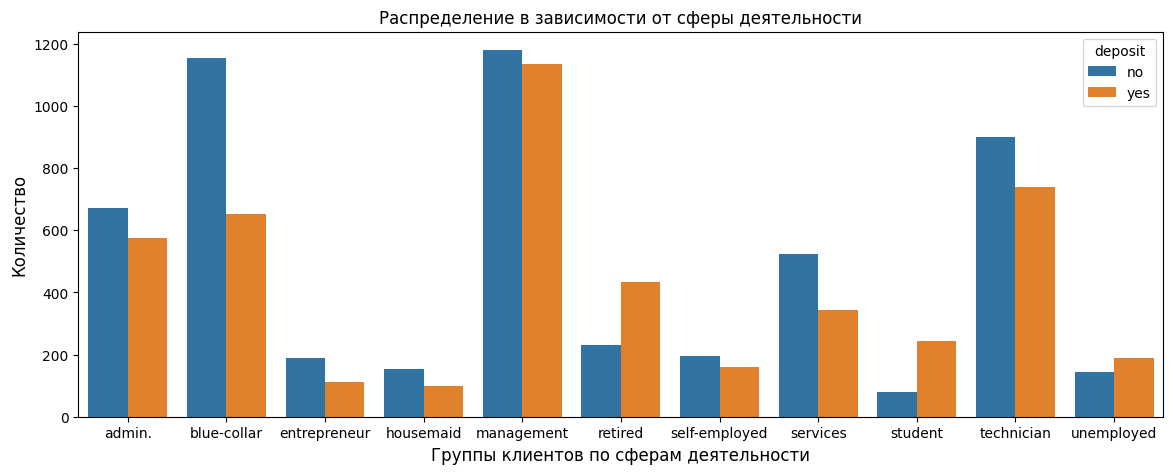

In [28]:
#создание визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
group_job = f_df.groupby('job')['deposit'].value_counts().reset_index()
ax, fig = plt.subplots(figsize = (14,5))
sns.barplot(group_job, x="job", y="count", hue="deposit")
plt.title('Распределение в зависимости от сферы деятельности')
plt.xlabel('Группы клиентов по сферам деятельности', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.show()

----------
### Выводы по графику:
* Среди тех кто принял предложение о депозите больше всего среди менеджеров. Так же среди них больше всего тех, кто отказался.
* Следом по числу отказов идут "голубые воротнички", их примерно в два раза больше, чем тех, кто согласился.
* В большинстве групп больше тех клиентов, кто отказался от депозита, нежели тех, кто согласился. 
* Стоит отметить, что в группах: студенты, безработные, пенсионеры, больше тех, кто согласился на депозит. Возможно это связано с тем, что эти группы чаще испытывают необходимсть хранить ценности в более безопасном месте, нежели дома или в месте пребывания.
-----------


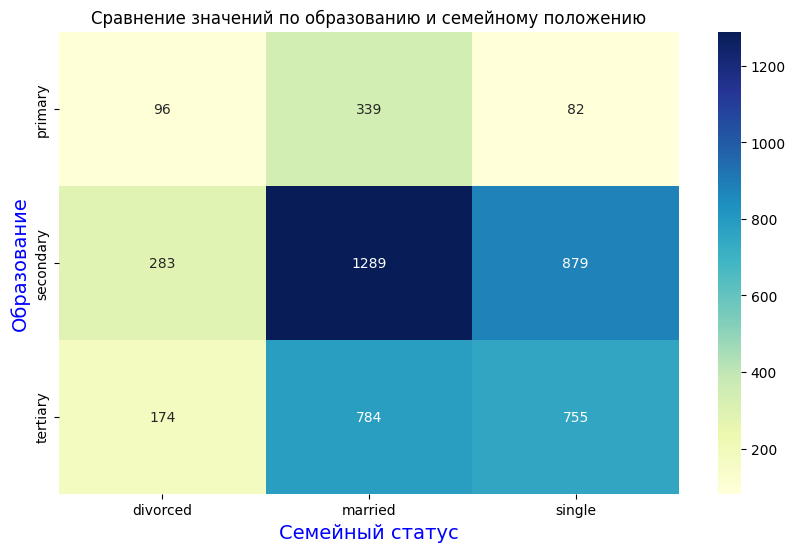

In [29]:
# Создание тепловой карты на основе сводной таблицы, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
filtered_df = f_df[f_df['deposit'] == 'yes']
group_dep_pos = filtered_df.groupby(['education', 'marital'])['deposit'].size().reset_index()

pivot_table = group_dep_pos.pivot(index='education', columns='marital', values='deposit')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Сравнение значений по образованию и семейному положению')
plt.xlabel('Семейный статус', fontsize = 14, color = 'blue')
plt.ylabel('Образование', fontsize = 14, color = 'blue')
plt.show()


---------
### Выводы по графику:
* Группа замужник(женатых) клиентов со средним образованием открывала депозит больше всего.
* Следом идёт группа людей без семьи и со средним образованием.
* Средние показателеи у групп клиентов с высшим образованием и либо женатых(замужних), либо без семьи.
* Самые низкие показатели у группы кдиентов с начальным образованием и либо разведённых, либо без семьи.
----------

###  Преобразование данных

In [30]:
# Преобразование признака 'education' (образование)
f_df['education'] = LabelEncoder().fit_transform(f_df['education'])
f_df['education']

0        1
1        1
2        1
3        1
4        2
        ..
11157    0
11158    1
11159    1
11160    1
11161    1
Name: education, Length: 10105, dtype: int32

In [31]:
# Преобразование бинарных переменных в 0 и 1.
f_df['deposit'] = f_df['deposit'].apply(lambda x: 0 if x=='no' else 1)
f_df['deposit'].value_counts()

deposit
0    5424
1    4681
Name: count, dtype: int64

In [33]:
f_df['default'] = f_df['default'].apply(lambda x: 0 if x == 'no' else 1)
f_df['housing'] = f_df['housing'].apply(lambda x: 0 if x == 'no' else 1)
f_df['loan'] = f_df['loan'].apply(lambda x: 0 if x == 'no' else 1)

In [34]:
print((f_df['default'].mean() + f_df['housing'].mean() + f_df['loan'].mean()).round(3))

0.635


In [35]:
# Кодирование номинальных признаков.
f_df = pd.get_dummies(f_df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

f_df.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'deposit', 'age_new',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [36]:
# удаление лишнего столбца
f_df = f_df.drop('age', axis = 1)

<Axes: >

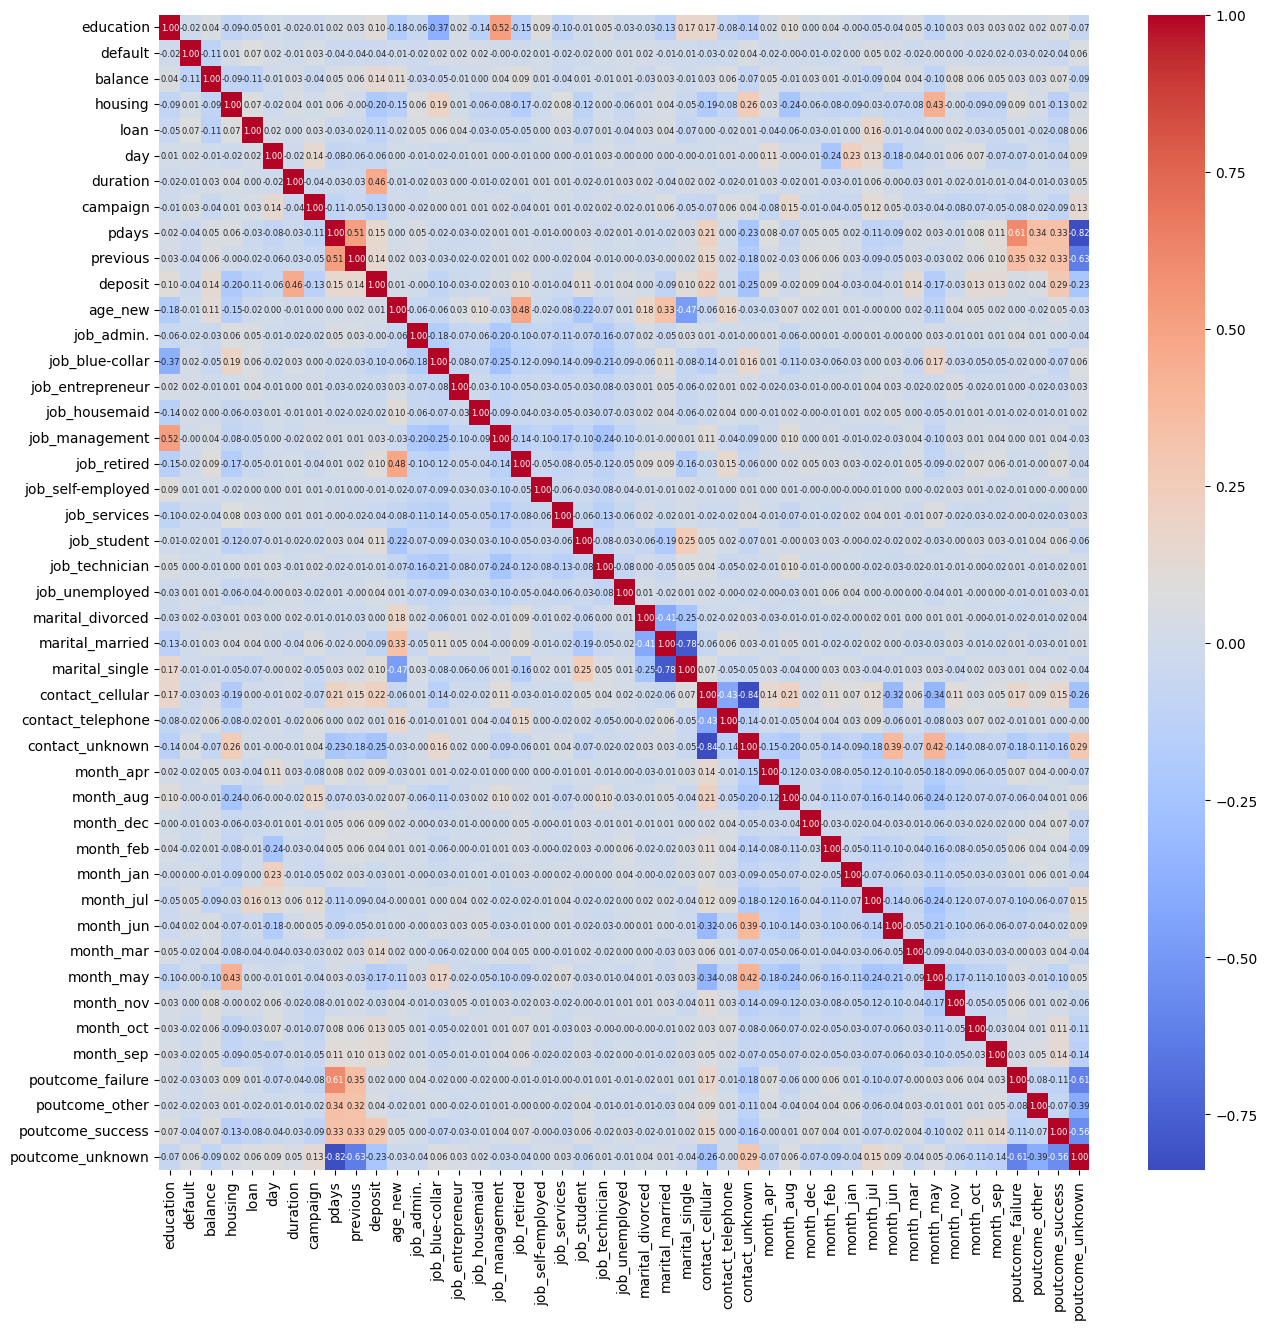

In [37]:
# Построение корреляционной матрицы
ax, fig = plt.subplots(figsize = (15,15))
corr_matrix = f_df.corr()
#mask = corr_matrix.abs() <= 0.5
sns.heatmap(corr_matrix,  annot = True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

---------------
>Признаки с сильной корреляцией:  contact_unknown, poutcome_unknown.
---------------


### Отбор признаков.

In [41]:
# Отбор 15-ти признаков с помощью SelectKBest
#Создание модели отбора признаков.
#выбираем три лучших признака
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
#Вывод названий столбцов. 
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [42]:
s_df = f_df[['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']]

s_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   balance           10105 non-null  float64
 1   housing           10105 non-null  int64  
 2   loan              10105 non-null  int64  
 3   duration          10105 non-null  int64  
 4   campaign          10105 non-null  int64  
 5   pdays             10105 non-null  int64  
 6   previous          10105 non-null  int64  
 7   contact_cellular  10105 non-null  bool   
 8   contact_unknown   10105 non-null  bool   
 9   month_mar         10105 non-null  bool   
 10  month_may         10105 non-null  bool   
 11  month_oct         10105 non-null  bool   
 12  month_sep         10105 non-null  bool   
 13  poutcome_success  10105 non-null  bool   
 14  poutcome_unknown  10105 non-null  bool   
dtypes: bool(8), float64(1), int64(6)
memory usage: 710.5 KB


### Скалирование признаков.

In [44]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
sc_df = scaler.fit_transform(s_df)

In [45]:
scaled_df = pd.DataFrame(sc_df, columns=s_df.columns)

In [46]:
scaled_df.iloc[:, 0].mean().round(2)

0.47

## Решение задачи классификации: логистическая регрессия и решающие деревья

### Создание модели логистической регрессии с отфильтрованными признаками.

In [61]:
# Повторное разбиение выборки
X = scaled_df
y = f_df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [103]:
# Создание модели логистической регрессии
model = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# получение метрики accuracy на тестовой выборке
y_test_pred = model.predict(X_test)
print('Accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Accuracy на тестовом наборе: 0.80
F1-score на тестовом наборе: 0.78


In [ ]:
# Подключение библиотеки GridSearchCV
from sklearn.model_selection import GridSearchCV

In [104]:
param_grid_expansion = [
                        {'penalty': ['l2', 'none'] , # тип регуляризации
                        'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
                        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
                       {'penalty': ['l1', 'l2'] ,
                        'solver': ['liblinear', 'saga'],
                        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}

                       ]
grid_search_exp = GridSearchCV(
    estimator = linear_model.LogisticRegression(
        random_state = 40,
        max_iter = 1000
    ),
    param_grid = param_grid_expansion,
    cv = 5,
    n_jobs = -1
)
    
%time grid_search_exp.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_exp.score(X_test, y_test)))
y_test_pred = grid_search_exp.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_exp.best_params_))

CPU times: total: 1.06 s
Wall time: 3.68 s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'none', 'solver': 'lbfgs'}


### Создание модели дерева решений и подбор гиперпараметров.

In [74]:
# Обучение модели решающих деревьев
model_tree = tree.DecisionTreeClassifier (criterion = 'entropy', random_state=42)

model_tree.fit(X_train, y_train)

y_test_pred = model_tree.predict(X_test)
print('Accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Accuracy на тестовом наборе: 0.75
F1-score на тестовом наборе: 0.74


In [85]:
# Подбор оптимальных гиперпараметров с помощью GridSearchCV.
param_grid = {'criterion':['gini', 'entropy'],
              'min_samples_leaf': list(range(3, 54, 3)),
              'max_depth': list(range(4, 40, 2))
              }
grid_search = GridSearchCV(
    estimator = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 40),
    param_grid=param_grid,
    cv = 5,
    n_jobs = 7
)

%time grid_search.fit(X_train, y_train) 
print("Accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 1.25 s
Wall time: 9.24 s
Accuracy на тестовом наборе: 0.80
F1-score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 27}


---------
>Благодаря подбору параметров удалось немного поднять метрику модели.
---------



## Решение задачи классификации: ансамбли моделей и построение прогноза

### Создание модели случайного леса и подбор параметров.

In [92]:
# Подбор оптимальных гиперпараметров с помощью GridSearchCV.
param_grid = {'n_estimators': [10, 1000, 20],
              'min_samples_leaf': [2,5,7, 10],
              'max_depth': [3,5,7],
              }
grid_search = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state = 40),
    param_grid=param_grid,
    cv = 5,
    n_jobs = 7
)

%time grid_search.fit(X_train, y_train) 
print("Accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 3.8 s
Wall time: 32.6 s
Accuracy на тестовом наборе: 0.82
F1-score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 1000}


In [93]:
# Подбор оптимальных гиперпараметров с помощью GridSearchCV - дополнение, чтобы проверить большее кол-во деревьев в модели
param_grid = {'n_estimators': [1000, 1500, 20],
              'min_samples_leaf': [2,5,7, 10],
              'max_depth': [3,5,7],
              }
grid_search = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state = 40),
    param_grid=param_grid,
    cv = 5,
    n_jobs = 7
)

%time grid_search.fit(X_train, y_train) 
print("Accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 5.5 s
Wall time: 1min 14s
Accuracy на тестовом наборе: 0.82
F1-score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 1500}


In [94]:
param_grid = {'n_estimators': [1000, 1500, 20],
              'min_samples_leaf': [2,3,4,5,7],
              'max_depth': [3,5,7,9],
              }
grid_search = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state = 40),
    param_grid=param_grid,
    cv = 5,
    n_jobs = 7
)

%time grid_search.fit(X_train, y_train) 
print("Accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 4.81 s
Wall time: 2min 10s
Accuracy на тестовом наборе: 0.83
F1-score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 1000}


In [95]:
param_grid = {'n_estimators': [1000, 1500, 20],
              'min_samples_leaf': [2,3,4,5,7],
              'max_depth': [9,10,11,12],
              }
grid_search = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state = 40),
    param_grid=param_grid,
    cv = 5,
    n_jobs = 7
)

%time grid_search.fit(X_train, y_train) 
print("Accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 4.67 s
Wall time: 2min 52s
Accuracy на тестовом наборе: 0.83
F1-score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 1000}


In [102]:
rf_1 = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini',min_samples_leaf = 5,max_depth = 10,random_state = 42)

rf_1.fit(X_train, y_train)

y_test_pred = rf_1.predict(X_test)

print("Accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print('Recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


Accuracy на тестовом наборе: 0.83
Recall на тестовом наборе: 0.83
F1-score на тестовом наборе: 0.82


### Создание градентного бустнига и подбор гиперпараметров.

In [100]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# Обучение модели градиентного бустинга
gb_model = GradientBoostingClassifier(learning_rate = 0.05,n_estimators = 300,min_samples_leaf = 5,max_depth = 5,random_state = 42)
gb_model.fit(X_train, y_train)

# Оценка качества модели градиентного бустинга
gb_accuracy = gb_model.score(X_test, y_test)
gb_y_test_pred = gb_model.predict(X_test)
gb_f1_score = metrics.f1_score(y_test, gb_y_test_pred)

print("\nГрадиентный бустинг:")
print("Accuracy на тестовом наборе: {:.2f}".format(gb_accuracy))
print("F1-score на тестовом наборе: {:.2f}".format(gb_f1_score))



Градиентный бустинг:
Accuracy на тестовом наборе: 0.82
F1-score на тестовом наборе: 0.81


--------
>Градиентный бустинг показал такие же значения метрики ниже, чем у модели Случайного Леса с оптимальными гиперпараметрами.
------------


In [101]:
#подбор оптимальных гиперпараметров для модели градиентного бустинга
param_grid = {'n_estimators': [50, 600, 50],
              'min_samples_leaf': [2,3,4,5,6,7],
              'max_depth': [3,6,9,10,11],
              'learning_rate' : [0.05, 0.1, 0.15]
              }
grid_search = GridSearchCV(
    estimator = GradientBoostingClassifier(random_state = 40),
    param_grid=param_grid,
    cv = 5,
    n_jobs = 7
)

%time grid_search.fit(X_train, y_train) 
print("Accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 8.81 s
Wall time: 14min 16s
Accuracy на тестовом наборе: 0.83
F1-score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 600}


### Создание стека с оптимальными гиперпараметрами.

In [107]:
# объединение моделей с оптимальными гиперпараметрами в стек
from sklearn.ensemble import StackingClassifier
#rf_b = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', min_samples_leaf = 5, max_depth = 10, random_state = 42)
tree_b = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth = 10, min_samples_leaf = 27,random_state = 42)
gb_b = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 3, min_samples_leaf = 4, n_estimators = 600, random_state = 42)
lr_model = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
#создание стека
estimators = [
    ( 'tr', tree_b),
    ('gb', gb_b),
    ('lr', lr_model)   
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=linear_model.LogisticRegression())

# Обучение стекинга
stacking_model.fit(X_train, y_train)

# Оценка качества стекинга на тестовом наборе данных
stacking_accuracy = stacking_model.score(X_test, y_test)
stacking_y_test_pred = stacking_model.predict(X_test)
stacking_f1_score = metrics.f1_score(y_test, stacking_y_test_pred)
stacking_precision = metrics.precision_score(y_test, stacking_y_test_pred)

print("Stacking модель:")
print("Precision стекинга на тестовом наборе: {:.2f}".format(stacking_precision))
print("Accuracy на тестовом наборе: {:.2f}".format(stacking_accuracy))
print("F1-score на тестовом наборе: {:.2f}".format(stacking_f1_score))


Stacking модель:
Precision стекинга на тестовом наборе: 0.81
Accuracy на тестовом наборе: 0.83
F1-score на тестовом наборе: 0.81


### Задание 5

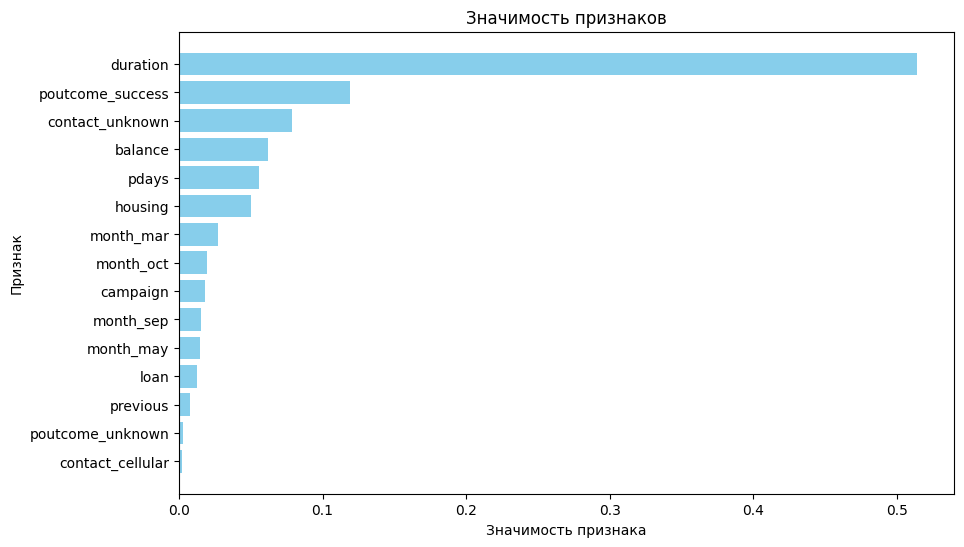

In [112]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
gb = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 3, min_samples_leaf = 4, n_estimators = 600, random_state = 42)

gb.fit(X_train, y_train)
feature_importances = gb_model.feature_importances_
feature_importance_dict = dict(zip(X.columns, feature_importances))

sorted_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False))

# Построение графика со всеми значениями важности признаков
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_feature_importance_dict.keys()), list(sorted_feature_importance_dict.values()), color='skyblue')
plt.xlabel('Значимость признака')
plt.ylabel('Признак')
plt.title('Значимость признаков')
plt.show()

### Оптимизация с помощью Optuna

In [138]:
# реализация гиперпараметров случайного леса с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 400, 1)
  max_depth = trial.suggest_int('max_depth', 3, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 12, 1)
  random_state = 40

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [139]:

%%time
# Создание объекта исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=30)

[I 2024-03-06 17:14:11,728] A new study created in memory with name: RandomForestClassifier
[I 2024-03-06 17:14:12,435] Trial 0 finished with value: 0.8221906116642957 and parameters: {'n_estimators': 205, 'max_depth': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8221906116642957.
[I 2024-03-06 17:14:13,589] Trial 1 finished with value: 0.8400438665204449 and parameters: {'n_estimators': 267, 'max_depth': 9, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8400438665204449.
[I 2024-03-06 17:14:14,879] Trial 2 finished with value: 0.8606965174129354 and parameters: {'n_estimators': 230, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8606965174129354.
[I 2024-03-06 17:14:16,527] Trial 3 finished with value: 0.8379434286607282 and parameters: {'n_estimators': 358, 'max_depth': 19, 'min_samples_leaf': 11}. Best is trial 2 with value: 0.8606965174129354.
[I 2024-03-06 17:14:17,322] Trial 4 finished with value: 0.8242539081004263 and parameters: {'n_e

CPU times: total: 23.5 s
Wall time: 23.7 s


In [140]:
# Вывод результатов метрики на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 112, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [141]:
# Расчёт точности для тестовой выборки
model = ensemble.RandomForestClassifier(n_estimators = 126, max_depth = 28, min_samples_leaf = 2, random_state = 40)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81


In [147]:
#дополнительное обучение модели на всех признаках
new_df = f_df.copy()
scaled_new_df = scaler.fit_transform(new_df)

sn_df = pd.DataFrame(scaled_new_df, columns=new_df.columns)
sn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   education          10105 non-null  float64
 1   default            10105 non-null  float64
 2   balance            10105 non-null  float64
 3   housing            10105 non-null  float64
 4   loan               10105 non-null  float64
 5   day                10105 non-null  float64
 6   duration           10105 non-null  float64
 7   campaign           10105 non-null  float64
 8   pdays              10105 non-null  float64
 9   previous           10105 non-null  float64
 10  deposit            10105 non-null  float64
 11  age_new            10105 non-null  float64
 12  job_admin.         10105 non-null  float64
 13  job_blue-collar    10105 non-null  float64
 14  job_entrepreneur   10105 non-null  float64
 15  job_housemaid      10105 non-null  float64
 16  job_management     101

In [148]:
X = sn_df.drop(['deposit'], axis=1)
y = f_df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [149]:
%%time
# Создание объекта исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=30)

[I 2024-03-06 17:32:30,864] A new study created in memory with name: RandomForestClassifier
[I 2024-03-06 17:32:32,629] Trial 0 finished with value: 0.8513092269326684 and parameters: {'n_estimators': 361, 'max_depth': 10, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.8513092269326684.
[I 2024-03-06 17:32:34,821] Trial 1 finished with value: 0.9262244265344081 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9262244265344081.
[I 2024-03-06 17:32:35,722] Trial 2 finished with value: 0.9526488513830287 and parameters: {'n_estimators': 106, 'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9526488513830287.
[I 2024-03-06 17:32:37,743] Trial 3 finished with value: 0.9410112359550562 and parameters: {'n_estimators': 270, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9526488513830287.
[I 2024-03-06 17:32:39,197] Trial 4 finished with value: 0.8636363636363636 and parameters: {'n

CPU times: total: 32 s
Wall time: 32.4 s


In [150]:
# Вывод результатов метрики на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 88, 'max_depth': 24, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.95


In [152]:
# Расчёт точности для тестовой выборки
model = ensemble.RandomForestClassifier(n_estimators = 88, max_depth = 24, min_samples_leaf = 2, random_state = 40)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.85
